<a href="https://colab.research.google.com/github/ashishar/q_character/blob/main/mnist_with_qnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchvision
# !pip install qiskit-machine-learning
import importlib

# Check if torchvision is installed
try:
    importlib.import_module('torchvision')
    print("torchvision is already installed.")
except ImportError:
    print("torchvision is not installed. Installing...")
    # Install torchvision using pip
    try:
        import pip
        pip.main(['install', 'torchvision'])
        print("torchvision installed successfully.")
    except Exception as e:
        print("Error occurred while installing torchvision:", str(e))

try:
    importlib.import_module('qiskit')
    print("qiskit is already installed.")
except ImportError:
    print("qiskit is not installed. Installing...")
    # Install torchvision using pip
    try:
        import pip
        pip.main(['install', 'qiskit'])
        print("qiskit installed successfully.")
    except Exception as e:
        print("Error occurred while installing qiskit:", str(e))

try:
    importlib.import_module('qiskit_machine_learning')
    print("qiskit-machine-learning is already installed.")
except ImportError:
    print("qiskit-machine-learning is not installed. Installing...")
    # Install torchvision using pip
    try:
        import pip
        pip.main(['install', 'qiskit-machine-learning'])
        print("qiskit-machine-learning installed successfully.")
    except Exception as e:
        print("Error occurred while installing qiskit-machine-learning:", str(e))


torchvision is already installed.
qiskit is not installed. Installing...


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting qiskit

Downloading qiskit-1.0.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.6 MB)

Output()

Collecting rustworkx>=0.14.0 (from qiskit)

Downloading rustworkx-0.14.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)

Output()

Requirement already satisfied: numpy<2,>=1.17 in /usr/local/lib/python3.10/dist-packages (from qiskit) (1.25.2)

Requirement already satisfied: scipy>=1.5 in /usr/local/lib/python3.10/dist-packages (from qiskit) (1.11.4)

Requirement already satisfied: sympy>=1.3 in /usr/local/lib/python3.10/dist-packages (from qiskit) (1.12)

Collecting dill>=0.3 (from qiskit)

Downloading dill-0.3.8-py3-none-any.whl (116 kB)

Output()

Requirement already satisfied: python-dateutil>=2.8.0 in /usr/local/lib/python3.10/dist-packages (from qiskit) (2.8.2)

Collecting stevedore>=3.0.0 (from qiskit)

Downloading stevedore-5.2.0-py3-none-any.whl (49 kB)

Output()

Requirement already satisfied: typing-extensions in /usr/local/lib/python3.10/dist-packages (from qiskit) (4.11.0)

Collecting symengine>=0.11 (from qiskit)

Downloading symengine-0.11.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (39.4 MB)

Output()

Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.10/dist-packages (from python-dateutil>=2.8.0->qiskit) (1.16.0)

Collecting pbr!=2.1.0,>=2.0.0 (from stevedore>=3.0.0->qiskit)

Downloading pbr-6.0.0-py2.py3-none-any.whl (107 kB)

Output()

Requirement already satisfied: mpmath>=0.19 in /usr/local/lib/python3.10/dist-packages (from sympy>=1.3->qiskit) (1.3.0)

Installing collected packages: symengine, rustworkx, pbr, dill, stevedore, qiskit

Successfully installed dill-0.3.8 pbr-6.0.0 qiskit-1.0.2 rustworkx-0.14.2 stevedore-5.2.0 symengine-0.11.0

qiskit installed successfully.
qiskit-machine-learning is not installed. Installing...


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting qiskit-machine-learning

Downloading qiskit_machine_learning-0.7.2-py3-none-any.whl (97 kB)

Output()

Collecting qiskit>=0.44 (from qiskit-machine-learning)

Using cached qiskit-1.0.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.6 MB)

Collecting qiskit-algorithms>=0.2.0 (from qiskit-machine-learning)

Downloading qiskit_algorithms-0.3.0-py3-none-any.whl (308 kB)

Output()

Requirement already satisfied: scipy>=1.4 in /usr/local/lib/python3.10/dist-packages (from qiskit-machine-learning) (1.11.4)

Requirement already satisfied: numpy>=1.17 in /usr/local/lib/python3.10/dist-packages (from qiskit-machine-learning) (1.25.2)

Requirement already satisfied: psutil>=5 in /usr/local/lib/python3.10/dist-packages (from qiskit-machine-learning) (5.9.5)

Requirement already satisfied: scikit-learn>=1.2.0 in /usr/local/lib/python3.10/dist-packages (from qiskit-machine-learning) (1.2.2)

Collecting fastdtw (from qiskit-machine-learning)

Downloading fastdtw-0.3.4.tar.gz (133 kB)

Output()

Preparing metadata (setup.py): started

Preparing metadata (setup.py): finished with status 'done'

Requirement already satisfied: setuptools>=40.1.0 in /usr/local/lib/python3.10/dist-packages (from qiskit-machine-learning) (67.7.2)

Collecting dill>=0.3.4 (from qiskit-machine-learning)

Using cached dill-0.3.8-py3-none-any.whl (116 kB)

Collecting rustworkx>=0.14.0 (from qiskit>=0.44->qiskit-machine-learning)

Using cached rustworkx-0.14.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)

Requirement already satisfied: sympy>=1.3 in /usr/local/lib/python3.10/dist-packages (from qiskit>=0.44->qiskit-machine-learning) (1.12)

Requirement already satisfied: python-dateutil>=2.8.0 in /usr/local/lib/python3.10/dist-packages (from qiskit>=0.44->qiskit-machine-learning) (2.8.2)

Collecting stevedore>=3.0.0 (from qiskit>=0.44->qiskit-machine-learning)

Using cached stevedore-5.2.0-py3-none-any.whl (49 kB)

Requirement already satisfied: typing-extensions in /usr/local/lib/python3.10/dist-packages (from qiskit>=0.44->qiskit-machine-learning) (4.11.0)

Collecting symengine>=0.11 (from qiskit>=0.44->qiskit-machine-learning)

Using cached symengine-0.11.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (39.4 MB)

Requirement already satisfied: joblib>=1.1.1 in /usr/local/lib/python3.10/dist-packages (from scikit-learn>=1.2.0->qiskit-machine-learning) (1.4.0)

Requirement already satisfied: threadpoolctl>=2.0.0 in /usr/local/lib/python3.10/dist-packages (from scikit-learn>=1.2.0->qiskit-machine-learning) (3.4.0)

Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.10/dist-packages (from python-dateutil>=2.8.0->qiskit>=0.44->qiskit-machine-learning) (1.16.0)

Collecting pbr!=2.1.0,>=2.0.0 (from stevedore>=3.0.0->qiskit>=0.44->qiskit-machine-learning)

Using cached pbr-6.0.0-py2.py3-none-any.whl (107 kB)

Requirement already satisfied: mpmath>=0.19 in /usr/local/lib/python3.10/dist-packages (from sympy>=1.3->qiskit>=0.44->qiskit-machine-learning) (1.3.0)

Building wheels for collected packages: fastdtw

Building wheel for fastdtw (setup.py): started

Building wheel for fastdtw (setup.py): finished with status 'done'

Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512619 sha256=c6c1ce8b33b280ae36e3eb92f339b8334d5ac2e16846b61da45e37d751b33975

Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4

Successfully built fastdtw

Installing collected packages: symengine, rustworkx, pbr, fastdtw, dill, stevedore, qiskit, qiskit-algorithms, qiskit-machine-learning

Successfully installed dill-0.3.8 fastdtw-0.3.4 pbr-6.0.0 qiskit-1.0.2 qiskit-algorithms-0.3.0 qiskit-machine-learning-0.7.2 rustworkx-0.14.2 stevedore-5.2.0 symengine-0.11.0

qiskit-machine-learning installed successfully.


In [2]:
# prompt: mount gdrive and import a file named quantum_circuit_simulator.py

from google.colab import drive
drive.mount('/content/drive')

# Change directory to the desired location where the file is stored.
%cd /content/drive/MyDrive/

# Import the file named quantum_circuit_simulator.py
import quantum_circuit_simulator


Mounted at /content/drive
/content/drive/MyDrive


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split


from quantum_circuit_simulator import quantum_circuit

In [9]:

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Select 1000 random images from the dataset
random_indices = np.random.choice(len(trainset), size=1000, replace=False)
train_dataset = torch.utils.data.Subset(trainset, random_indices)



# Create a DataLoader for the random subset
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load the MNIST dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Select 1000 random images from the dataset
random_indices = np.random.choice(len(test_dataset), size=300, replace=False)
random_testset = torch.utils.data.Subset(trainset, random_indices)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

x of torch.Size([1, 28, 28]) :


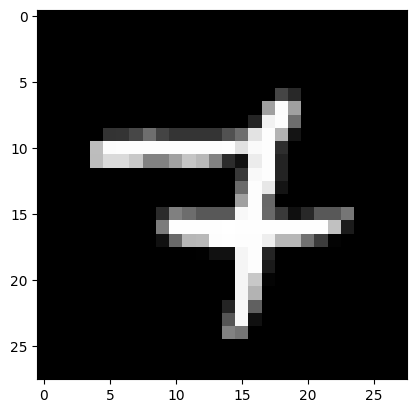

true label = y = 7

(x_min, x_max) =  (0.0, 1.0)


In [10]:
idx = np.random.choice(len(train_dataset))

# Access the data and label using the selected index
x, y = trainset[idx]

# Display the image
print(f'x of {x.shape} :')
plt.imshow(x.squeeze(), cmap='gray')  # Assuming MNIST images are grayscale (1 channel)
plt.show()

# Print the true label
print(f'true label = y = {y}\n')

# Print the minimum and maximum pixel values
print(f'(x_min, x_max) =  {x.min().item(), round(x.max().item(), 3)}')

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"    # Get gpu or cpu device for training
print(f"Using {device} device\n")

#=====================================================================================


class QNN(torch.nn.Module):                              # Define model
    def __init__(self, n, L):                            # number of qubits = n, number of quantum layers = L
        super().__init__()

        self.flatten = nn.Flatten()

        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = torch.nn.Parameter(angles)                   # it makes angles learnable parameters


        self.linear = nn.Linear(2**n, 10)                          # classical linear layer


    def forward(self, x):
        x = F.pad(x, (2 ,2, 2, 2), "constant", 0)                  # (left, right, top, bottom) padding
        x = self.flatten(x)
        x /= torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)   # L2 normalization to change x --> |x⟩

        '''initializing parameterized quantum circuits (PQC)'''
        qc = quantum_circuit(num_qubits = n, state_vector = x.T)   # each column is a feature-vector of an example
        for l in range(L):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))           # rotation part of lth quantum layer
            qc.cx_linear_layer()                                   # entangling part of lth quantum layer

        'after passing through the PQC, measurement on the output-ket in the computational basis'
        x = torch.real(qc.probabilities())               # each column is a probabilities-vector for an example
                                                         # x.shape = (dim, batch size)

        #print(torch.sum(x, dim=0))                      # to see whether probabilities add up to 1 or not

        x = self.linear(x.T)                             # x.shape = (batch size, 10),  classical linear layer

        return x

Using cpu device



In [12]:
def performance_estimate(dataset, model, loss_fn, train_or_test):
    '''this function computes accuracy and loss of a model on the training or test set'''
    data_size = len(dataset)

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(dataloader)

    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            accuracy += (pred.argmax(1) == y).sum().item()
            loss += loss_fn(pred, y).item()
    accuracy /= data_size                                            # accuracy lies in the interval [0, 1]
    loss /= num_batches
    print(f"{train_or_test} accuracy: {round(accuracy, 3)},  {train_or_test} loss: {round(loss,3)}")
    return accuracy, loss




def one_epoch(model, loss_fn, optimizer, dataset, batch_size):

    A_train, L_train, A_test, L_test = [], [], [], []

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass
        loss = loss_fn(out, y)

        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients


        if batch % batch_size == 0:
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
            accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
            print()

            A_train.append(accuracy_train)
            L_train.append(loss_train)
            A_test.append(accuracy_test)
            L_test.append(loss_test)

            #print(f"train loss: {round(loss,3)}")

    return A_train, L_train, A_test, L_test



def training(dataset, batch_size, n, L, lr_, weight_decay_, epochs):

    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)

    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs):
        print(f"Epoch {t+1} ---------------------------------- \n")
        #As training progress, computing and appending loss and accuracy of the model on train and test set
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size)
        A_Train += A_train
        L_Train += L_train
        A_Test += A_test
        L_Test += L_test

        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')

    model_state_dict = model.state_dict()           # for saving or loading the trained model

    return A_Train, L_Train, A_Test, L_Test, model_state_dict

In [ ]:
%%time

n = 10
dim = 2**n              # dimension of the n-qubit Hilbert space
L = 1

n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print(f"number of angles (learnable parameters of quantum circuit) = {n_angs}\n ")

#--------------------------------------------------------------------------------------


batch_size = 64
print(f'batch_size = {batch_size}\n')


#----------------------------------------------------------------------------------


A_Train, L_Train, A_Test, L_Test, model_state_dict = training(train_dataset, batch_size=batch_size, n=n, L=L,
                                                              lr_=1e-1, weight_decay_=1e-10, epochs=5)


print(f' ~~~~~ training is done ~~~~~\n')

number of qubits =  10
number of quantum layers =  1
number of angles (learnable parameters of quantum circuit) = 10
 
batch_size = 64

Epoch 1 ---------------------------------- 

train accuracy: 0.381,  train loss: 2.272
test  accuracy: 0.377,  test  loss: 2.275

Epoch 2 ---------------------------------- 



In [ ]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {test_dataset[idx][1]}\n')


out_ = model(x.view(1, 1, 28, 28)).detach().flatten()
prob = F.softmax(out_, dim=0)
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(np.arange(10), prob)
plt.ylabel('probability')
plt.xlabel('class labels')
plt.show()